## sum up DeepSeek-v3 token distribution layer-wise

In [ ]:
import os
import pandas as pd
import numpy as np
from glob import glob
import re

# Natural Sorting is very useful for sorting filenames with numbers in them.
def natural_sort_key(s):
    """Generate a key for sorting strings with embedded numbers naturally."""
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def aggregate_layer_expert_tokens(input_folder, output_csv_path, expected_layers=58, expected_experts=256, max_rows=5000):
    """
    Reads multiple token distribution CSVs (each representing a layer).
    Aggregates each file into a single row, with the total number of tokens received by each expert.
    The final CSV will contain one row per layer, and each column represents an expert.

    Args:
        input_folder (str): Folder containing per-layer token distribution CSV files.
        output_csv_path (str): Path to save the aggregated output CSV.
        expected_layers (int): Expected number of layers/files.
        expected_experts (int): Expected number of experts per layer (i.e., columns).
        max_rows (int): Maximum number of rows to process from each CSV file.
    """
    result_rows = []
    # Use natural sorting to ensure correct order (e.g., layer_3 comes before layer_10)
    file_list = sorted(glob(os.path.join(input_folder, "*.csv")), key=natural_sort_key)
    
    if len(file_list) != expected_layers:
        print(f"[Warning] Expecting {expected_layers} files, but found {len(file_list)}")

    for i, csv_path in enumerate(file_list):
        try:
            # Read only the first max_rows rows
            df = pd.read_csv(csv_path, header=None, nrows=max_rows)
        except Exception as e:
            print(f"[Error] Failed to read {csv_path}: {e}")
            continue

        if df.shape[1] != expected_experts:
            print(f"[Warning] {csv_path} has {df.shape[1]} columns, expected {expected_experts}")
        
        # Sum over rows (per column), resulting in total tokens received by each expert
        layer_token_sum = df.sum(axis=0).values  # shape: [256]
        result_rows.append(layer_token_sum)

    # Combine all layer vectors into a single DataFrame
    result_df = pd.DataFrame(result_rows)
    result_df.columns = [f"expert_{i}" for i in range(expected_experts)]
    result_df.index.name = "layer_id"

    # Save to aggregated CSV
    result_df.to_csv(output_csv_path, index=False)
    print(f"[Done] Aggregated CSV saved to: {output_csv_path}")
    print(f"[Info] Processed up to {max_rows} rows per file")


In [8]:
aggregate_layer_expert_tokens(
    input_folder=r"C:\Users\bingxche\data\Projects\moe_token_dist\deepseek-v3_tp8_0_copy",
    output_csv_path=r"C:\Users\bingxche\data\Projects\moe_token_dist\deepseek-v3_tp8_0_copy\aggregated_tokens_analysis.csv",
)

[Done] Aggregated CSV saved to: C:\Users\bingxche\data\Projects\moe_token_dist\deepseek-v3_tp8_0_copy\aggregated_tokens_analysis.csv
[Info] Processed up to 5000 rows per file


## preprocess token dist csv file

In [ ]:
import shutil
import os
import glob

def process_csv_files(input_folder):
    # 创建输出文件夹（如果不存在）
    output_folder = input_folder + "_rank_0"
    os.makedirs(output_folder, exist_ok=True)
    
    # 获取文件夹中所有CSV文件的路径
    csv_files = glob.glob(os.path.join(input_folder, "*rank_0.csv"))
    
    if not csv_files:
        print(f"No 'rank_0.csv' files found in {input_folder}")
        return
    
    print(f"Found {len(csv_files)} 'rank_0.csv' files to process")
    
    # 复制每个CSV文件到输出文件夹
    for csv_path in csv_files:
        try:
            shutil.copy(csv_path, output_folder)
            print(f"Copied {csv_path} to {output_folder}")
        except Exception as e:
            print(f"Error copying file {csv_path}: {e}")
    
    print(f"Processing complete. Files copied to {output_folder}")

# 使用示例 - 替换为您的实际文件夹路径
input_folder = r"C:\Users\bingxche\data\Projects\moe_token_dist\deepseek-v3_tp"  # 包含CSV文件的文件夹

# 执行批处理
process_csv_files(input_folder)


## test plot token dist for deepseek-v3

CSV file: /Users/chenbingxu/Downloads/moe_token_distribution/layer_3_token_distribution.csv
Shape: (1027, 256)


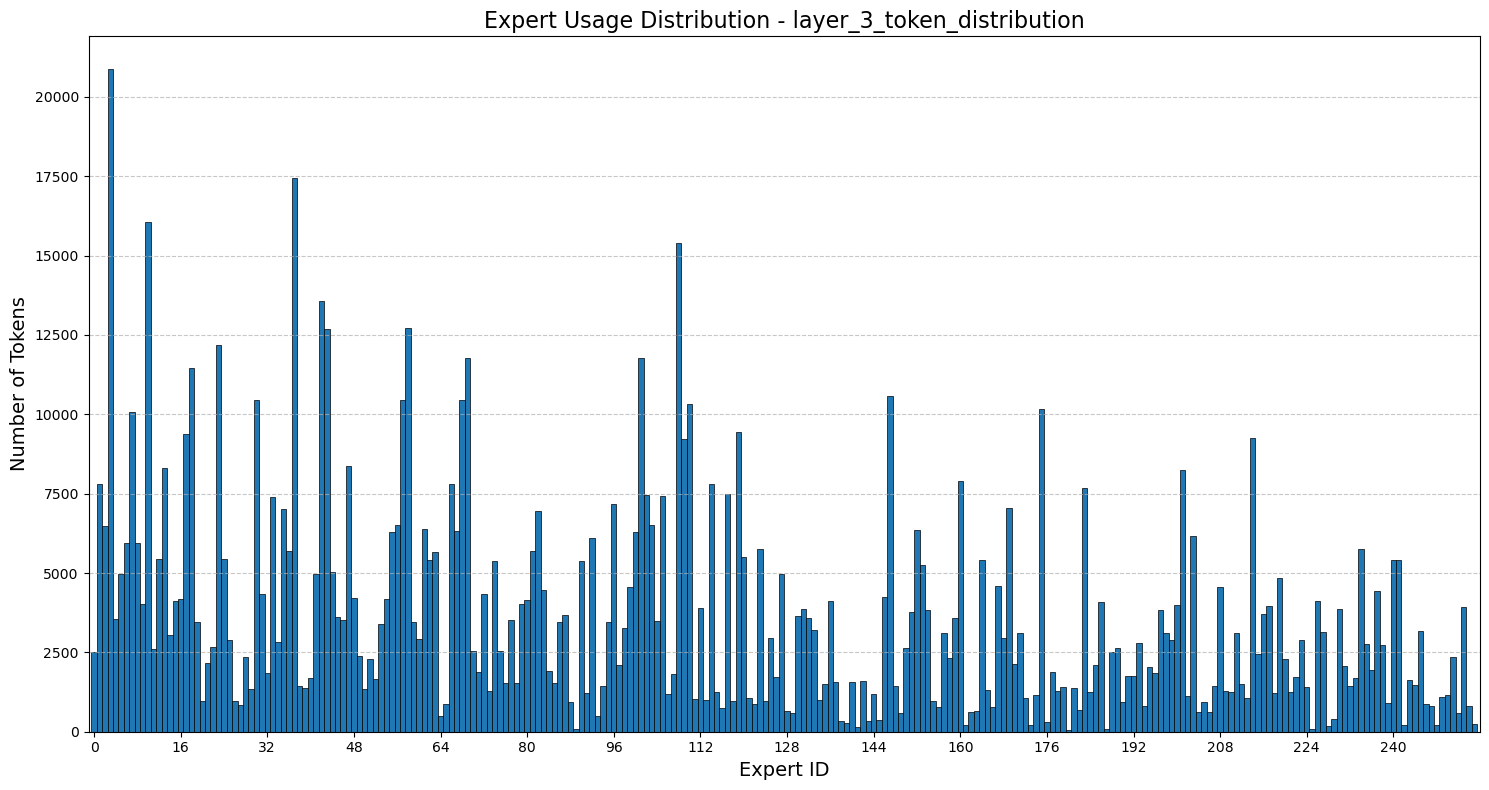

Total tokens processed: 950368
Most used expert ID: 3 with 20863 tokens
Least used expert ID: 180 with 64 tokens
Average tokens per expert: 3712.38


<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# 读取CSV文件
def process_csv_file(csv_path):
    # 读取CSV文件
    try:
        # 尝试直接读取，假设CSV没有标题行，只有数值
        df = pd.read_csv(csv_path, header=None)
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return None
    
    # 获取文件名（不含路径和扩展名）用作图表标题
    file_name = os.path.basename(csv_path)
    file_name = os.path.splitext(file_name)[0]
    
    # 打印数据基本信息
    print(f"CSV file: {csv_path}")
    print(f"Shape: {df.shape}")
    
    # 检查是否有256列
    if df.shape[1] != 256:
        print(f"Warning: Expected 256 columns but found {df.shape[1]}")
    
    # 计算每个expert的总和
    total_per_expert = df.sum(axis=0).values
    
    # 创建expert_id数组 (0-255)
    expert_ids = np.arange(len(total_per_expert))
    
    # 创建直方图
    plt.figure(figsize=(15, 8))
    plt.bar(expert_ids, total_per_expert, width=1.0, edgecolor='black', linewidth=0.5)
    
    # 添加标题和标签
    plt.title(f'{file_name}', fontsize=16)
    plt.xlabel('Expert ID(0-255)', fontsize=14)
    plt.ylabel('Number of Tokens', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 设置x轴范围和刻度
    plt.xlim(-1, len(expert_ids))
    plt.xticks(np.arange(0, len(expert_ids), 16))
    
    # 显示图表
    plt.tight_layout()
    plt.show()
    
    # 显示一些统计信息
    print(f"Total tokens processed: {np.sum(total_per_expert)}")
    print(f"Hottest expert ID: {np.argmax(total_per_expert)} with {np.max(total_per_expert)} tokens")
    print(f"Coldest expert ID: {np.argmin(total_per_expert)} with {np.min(total_per_expert)} tokens")
    print(f"Average tokens per expert: {np.mean(total_per_expert):.2f}")
    
    return total_per_expert

# 使用示例
# 替换下面的路径为您的CSV文件路径
csv_file_path = "/Users/chenbingxu/Downloads/moe_token_distribution/layer_3_token_distribution.csv"  
expert_usage = process_csv_file(csv_file_path)

# 如果需要保存结果图表到文件
plt.savefig("expert_usage_histogram.png", dpi=300, bbox_inches='tight')

## test plot for mixtral 8x7b

CSV file: C:\Users\bingxche\data\Projects\moe_token_dist\mixtral_8x7b_tp8_1\layer_0_token_distribution_rank_0.csv
Shape: (306, 8)


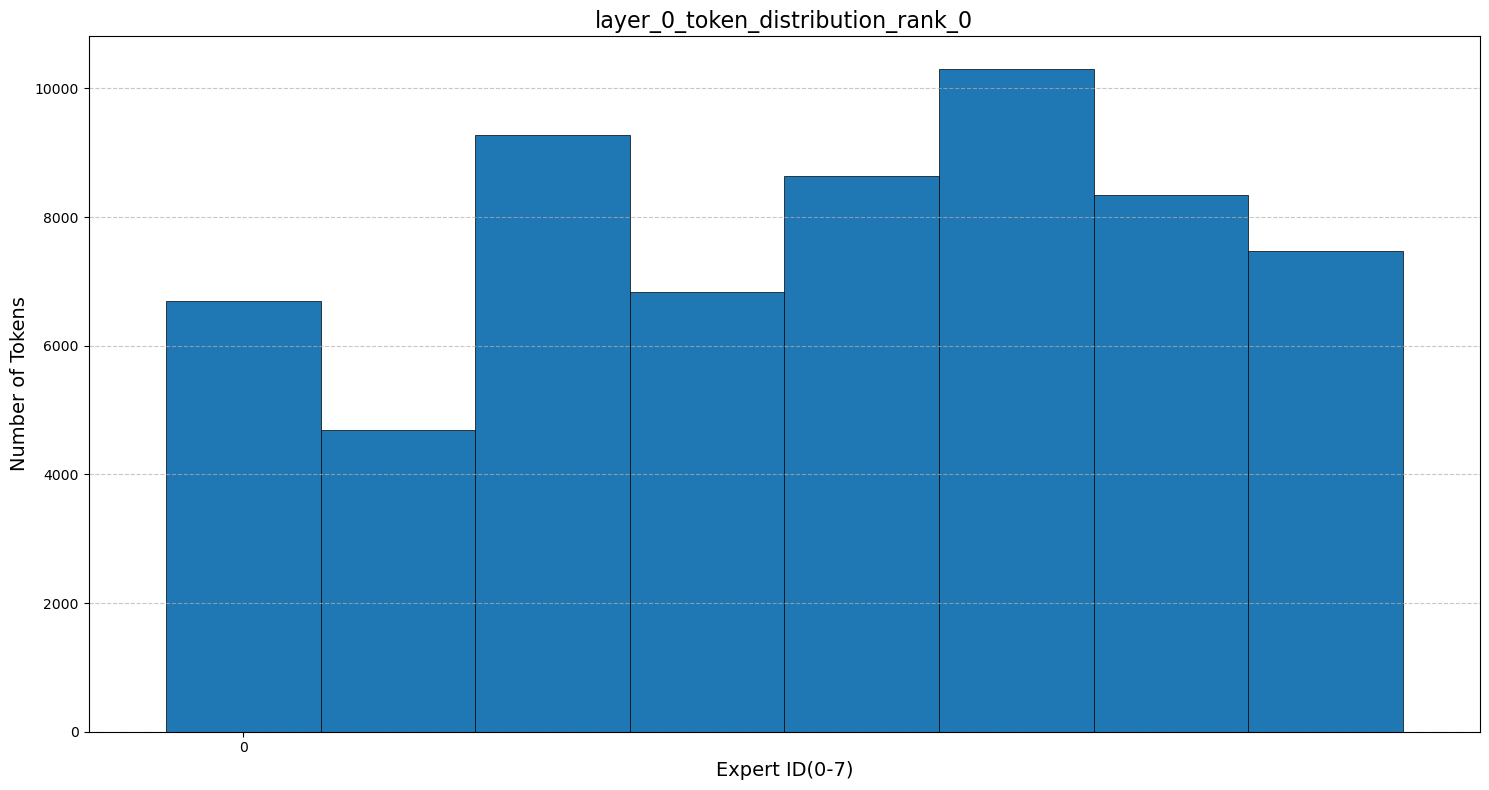

Total tokens processed: 62246
Hottest expert ID: 5 with 10294 tokens
Coldest expert ID: 1 with 4687 tokens
Average tokens per expert: 7780.75


<Figure size 640x480 with 0 Axes>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# 读取CSV文件
def process_csv_file(csv_path):
    # 读取CSV文件
    try:
        # 尝试直接读取，假设CSV没有标题行，只有数值
        df = pd.read_csv(csv_path, header=None)
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return None
    
    # 获取文件名（不含路径和扩展名）用作图表标题
    file_name = os.path.basename(csv_path)
    file_name = os.path.splitext(file_name)[0]
    
    # 打印数据基本信息
    print(f"CSV file: {csv_path}")
    print(f"Shape: {df.shape}")
    
    # 检查是否有8列
    if df.shape[1] != 8:
        print(f"Warning: Expected 8 columns but found {df.shape[1]}")
    
    # 计算每个expert的总和
    total_per_expert = df.sum(axis=0).values
    
    # 创建expert_id数组 (0-7)
    expert_ids = np.arange(len(total_per_expert))
    
    # 创建直方图
    plt.figure(figsize=(15, 8))
    plt.bar(expert_ids, total_per_expert, width=1.0, edgecolor='black', linewidth=0.5)
    
    # 添加标题和标签
    plt.title(f'{file_name}', fontsize=16)
    plt.xlabel('Expert ID(0-7)', fontsize=14)
    plt.ylabel('Number of Tokens', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 设置x轴范围和刻度
    plt.xlim(-1, len(expert_ids))
    plt.xticks(np.arange(0, len(expert_ids), 16))
    
    # 显示图表
    plt.tight_layout()
    plt.show()
    
    # 显示一些统计信息
    print(f"Total tokens processed: {np.sum(total_per_expert)}")
    print(f"Hottest expert ID: {np.argmax(total_per_expert)} with {np.max(total_per_expert)} tokens")
    print(f"Coldest expert ID: {np.argmin(total_per_expert)} with {np.min(total_per_expert)} tokens")
    print(f"Average tokens per expert: {np.mean(total_per_expert):.2f}")
    
    return total_per_expert

# 使用示例
# 替换下面的路径为您的CSV文件路径
csv_file_path = r"C:\Users\bingxche\data\Projects\moe_token_dist\mixtral_8x7b_tp8_1\layer_0_token_distribution_rank_0.csv"  
expert_usage = process_csv_file(csv_file_path)

# 如果需要保存结果图表到文件
plt.savefig("expert_usage_histogram.png", dpi=300, bbox_inches='tight')

## deepseek-v3 token dist plots

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

def process_csv_files(input_folder, output_folder):
    # 创建输出文件夹（如果不存在）
    os.makedirs(output_folder, exist_ok=True)
    
    # 获取文件夹中所有CSV文件的路径
    csv_files = glob.glob(os.path.join(input_folder, "*.csv"))
    
    if not csv_files:
        print(f"No CSV files found in {input_folder}")
        return
    
    print(f"Found {len(csv_files)} CSV files to process")
    
    # 处理每个CSV文件
    for csv_path in csv_files:
        process_single_csv_to_plot(csv_path, output_folder)
    
    print(f"Processing complete. Results saved to {output_folder}")


def process_single_csv_to_sumup(csv_path, output_folder):
    # 读取CSV文件
    try:
        # 尝试直接读取，假设CSV没有标题行，只有数值
        df = pd.read_csv(csv_path, header=None)
    except Exception as e:
        print(f"Error reading CSV file {csv_path}: {e}")
        return None
    
    # 获取文件名（不含路径和扩展名）用作图表标题
    file_name = os.path.basename(csv_path)
    file_name_no_ext = os.path.splitext(file_name)[0]
    
    print(f"Processing: {file_name}")
    print(f"Shape: {df.shape}")
    
    # 检查是否有256列
    if df.shape[1] != 256:
        print(f"Warning: Expected 256 columns but found {df.shape[1]}")
    
    # 计算每个expert的总和
    total_per_expert = df.sum(axis=0).values
    
    # 创建expert_id数组
    expert_ids = np.arange(len(total_per_expert))
    
    # 获取统计信息
    total_tokens = np.sum(total_per_expert)
    max_expert_id = np.argmax(total_per_expert)
    max_tokens = np.max(total_per_expert)
    min_expert_id = np.argmin(total_per_expert)
    min_tokens = np.min(total_per_expert)
    avg_tokens = np.mean(total_per_expert)
    
    
    # 打印一些统计信息到控制台
    print(f"  Total tokens: {total_tokens:,}")
    print(f"  Most used expert: ID {max_expert_id} with {max_tokens:,} tokens")
    print(f"  Least used expert: ID {min_expert_id} with {min_tokens:,} tokens")
    print(f"  Average tokens per expert: {avg_tokens:.2f}")
    
    return total_per_expert

def process_single_csv_to_plot(csv_path, output_folder):
    # 读取CSV文件
    try:
        # 尝试直接读取，假设CSV没有标题行，只有数值
        df = pd.read_csv(csv_path, header=None)
    except Exception as e:
        print(f"Error reading CSV file {csv_path}: {e}")
        return None
    
    # 获取文件名（不含路径和扩展名）用作图表标题
    file_name = os.path.basename(csv_path)
    file_name_no_ext = os.path.splitext(file_name)[0]
    
    print(f"Processing: {file_name}")
    print(f"Shape: {df.shape}")
    
    # 检查是否有256列
    if df.shape[1] != 256:
        print(f"Warning: Expected 256 columns but found {df.shape[1]}")
    
    # 计算每个expert的总和
    total_per_expert = df.sum(axis=0).values
    
    # 创建expert_id数组
    expert_ids = np.arange(len(total_per_expert))
    
    # 获取统计信息
    total_tokens = np.sum(total_per_expert)
    max_expert_id = np.argmax(total_per_expert)
    max_tokens = np.max(total_per_expert)
    min_expert_id = np.argmin(total_per_expert)
    min_tokens = np.min(total_per_expert)
    avg_tokens = np.mean(total_per_expert)
    
    # 创建直方图
    plt.figure(figsize=(16, 9))
    plt.bar(expert_ids, total_per_expert, width=1.0, edgecolor='black', linewidth=0.5)
    
    # 添加标题和标签
    plt.title(f'{file_name_no_ext}', fontsize=16)
    plt.xlabel('Expert ID(0-255)', fontsize=14)
    plt.ylabel('Number of Tokens', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 设置x轴范围和刻度
    plt.xlim(-1, len(expert_ids))
    plt.xticks(np.arange(0, len(expert_ids), 16))
    
    # 在图上显示统计信息
    stat_text = (
        f"Total tokens: {total_tokens:,}\n"
        f"Hottest: Expert {max_expert_id} ({max_tokens:,} tokens)\n"
        f"Coldest: Expert {min_expert_id} ({min_tokens:,} tokens)\n"
        f"Average: {avg_tokens:.2f} tokens per expert"
    )
    
    # 在图上添加统计信息文本框，将位置移到右上角
    plt.figtext(0.75, 0.95, stat_text, fontsize=12, 
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'), 
                verticalalignment='top')
    
    # 保存图表
    output_file = os.path.join(output_folder, f"{file_name_no_ext}_histogram.png")
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.close()  # 关闭图表以释放内存
    
    print(f"Saved histogram to: {output_file}")
    
    # 打印一些统计信息到控制台
    print(f"  Total tokens: {total_tokens:,}")
    print(f"  Most used expert: ID {max_expert_id} with {max_tokens:,} tokens")
    print(f"  Least used expert: ID {min_expert_id} with {min_tokens:,} tokens")
    print(f"  Average tokens per expert: {avg_tokens:.2f}")
    
    return total_per_expert

# 使用示例 - 替换为您的实际文件夹路径
input_folder = "/Users/chenbingxu/Downloads/moe_token_distribution/deepseek-v3_tp"  # 包含CSV文件的文件夹
output_folder = "/Users/chenbingxu/Downloads/moe_token_distribution_plots"  # 保存图表的文件夹

# 执行批处理
process_csv_files(input_folder, output_folder)

Found 58 CSV files to process
Processing: layer_28_token_distribution.csv
Shape: (1027, 256)
Saved histogram to: /Users/chenbingxu/Downloads/moe_token_distribution_plots/layer_28_token_distribution_histogram.png
  Total tokens: 950,368
  Most used expert: ID 12 with 33,188 tokens
  Least used expert: ID 225 with 1 tokens
  Average tokens per expert: 3712.38
Processing: layer_22_token_distribution.csv
Shape: (1027, 256)
Saved histogram to: /Users/chenbingxu/Downloads/moe_token_distribution_plots/layer_22_token_distribution_histogram.png
  Total tokens: 950,368
  Most used expert: ID 210 with 46,730 tokens
  Least used expert: ID 220 with 16 tokens
  Average tokens per expert: 3712.38
Processing: layer_57_token_distribution.csv
Shape: (1027, 256)
Saved histogram to: /Users/chenbingxu/Downloads/moe_token_distribution_plots/layer_57_token_distribution_histogram.png
  Total tokens: 950,368
  Most used expert: ID 216 with 36,492 tokens
  Least used expert: ID 86 with 0 tokens
  Average token

## mixtral token dist plot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

def process_csv_files(input_folder, output_folder):
    # 创建输出文件夹（如果不存在）
    os.makedirs(output_folder, exist_ok=True)
    
    # 获取文件夹中所有CSV文件的路径
    csv_files = glob.glob(os.path.join(input_folder, "*.csv"))
    
    if not csv_files:
        print(f"No CSV files found in {input_folder}")
        return
    
    print(f"Found {len(csv_files)} CSV files to process")
    
    # 处理每个CSV文件
    for csv_path in csv_files:
        process_single_csv(csv_path, output_folder)
    
    print(f"Processing complete. Results saved to {output_folder}")

def process_single_csv(csv_path, output_folder):
    # # 检查文件名是否以"rank_0.csv"结尾
    # if not csv_path.endswith("rank_0.csv"):
    #     print(f"Skipping file {csv_path} as it does not end with 'rank_0.csv'")
    #     return None

    # 读取CSV文件
    try:
        # 尝试直接读取，假设CSV没有标题行，只有数值
        df = pd.read_csv(csv_path, header=None)
    except Exception as e:
        print(f"Error reading CSV file {csv_path}: {e}")
        return None
    
    # 获取文件名（不含路径和扩展名）用作图表标题
    file_name = os.path.basename(csv_path)
    file_name_no_ext = os.path.splitext(file_name)[0]
    
    print(f"Processing: {file_name}")
    print(f"Shape: {df.shape}")
    
    # 检查是否有8列
    if df.shape[1] != 8:
        print(f"Warning: Expected 8 columns but found {df.shape[1]}")
    
    # 计算每个expert的总和
    total_per_expert = df.sum(axis=0).values
    
    # 创建expert_id数组
    expert_ids = np.arange(len(total_per_expert))
    
    # 获取统计信息
    total_tokens = np.sum(total_per_expert)
    max_expert_id = np.argmax(total_per_expert)
    max_tokens = np.max(total_per_expert)
    min_expert_id = np.argmin(total_per_expert)
    min_tokens = np.min(total_per_expert)
    avg_tokens = np.mean(total_per_expert)
    
    # 创建直方图
    plt.figure(figsize=(16, 9))
    plt.bar(expert_ids, total_per_expert, width=1.0, edgecolor='black', linewidth=0.5)
    
    # 添加标题和标签
    plt.title(f'{file_name_no_ext}', fontsize=16)
    plt.xlabel('Expert ID(0-7)', fontsize=14)
    plt.ylabel('Number of Tokens', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 设置x轴范围和刻度
    plt.xlim(-1, len(expert_ids))
    plt.xticks(np.arange(0, len(expert_ids)))
    
    # 在图上显示统计信息
    stat_text = (
        f"Total tokens: {total_tokens:,}\n"
        f"Hottest: Expert {max_expert_id} ({max_tokens:,} tokens)\n"
        f"Coldest: Expert {min_expert_id} ({min_tokens:,} tokens)\n"
        f"Average: {avg_tokens:.2f} tokens per expert"
    )
    
    # 在图上添加统计信息文本框，将位置移到右上角
    plt.figtext(0.75, 0.95, stat_text, fontsize=12, 
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'), 
                verticalalignment='top')
    
    # 保存图表
    output_file = os.path.join(output_folder, f"{file_name_no_ext}_histogram.png")
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.close()  # 关闭图表以释放内存
    
    print(f"Saved histogram to: {output_file}")
    
    # 打印一些统计信息到控制台
    print(f"  Total tokens: {total_tokens:,}")
    print(f"  Most used expert: ID {max_expert_id} with {max_tokens:,} tokens")
    print(f"  Least used expert: ID {min_expert_id} with {min_tokens:,} tokens")
    print(f"  Average tokens per expert: {avg_tokens:.2f}")
    
    return total_per_expert

# 使用示例 - 替换为您的实际文件夹路径
input_folder = r"C:\Users\bingxche\data\Projects\moe_token_dist\mixtral_8x7b_ep8_1_rank_0_eplb"  # 包含CSV文件的文件夹
output_folder = input_folder+"_plots"

# 执行批处理
process_csv_files(input_folder, output_folder)

Found 32 CSV files to process
Processing: layer_10_hotness.csv
Shape: (484, 8)
Saved histogram to: C:\Users\bingxche\data\Projects\moe_token_dist\mixtral_8x7b_ep8_1_rank_0_eplb_plots\layer_10_hotness_histogram.png
  Total tokens: 13,552
  Most used expert: ID 7 with 2,868 tokens
  Least used expert: ID 0 with 520 tokens
  Average tokens per expert: 1694.00
Processing: layer_11_hotness.csv
Shape: (484, 8)
Saved histogram to: C:\Users\bingxche\data\Projects\moe_token_dist\mixtral_8x7b_ep8_1_rank_0_eplb_plots\layer_11_hotness_histogram.png
  Total tokens: 13,552
  Most used expert: ID 7 with 2,692 tokens
  Least used expert: ID 0 with 696 tokens
  Average tokens per expert: 1694.00
Processing: layer_12_hotness.csv
Shape: (484, 8)
Saved histogram to: C:\Users\bingxche\data\Projects\moe_token_dist\mixtral_8x7b_ep8_1_rank_0_eplb_plots\layer_12_hotness_histogram.png
  Total tokens: 13,552
  Most used expert: ID 7 with 2,904 tokens
  Least used expert: ID 0 with 484 tokens
  Average tokens per

## EPLB

In [2]:
from typing import Tuple

import torch

def balanced_packing(weight: torch.Tensor, num_packs: int) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Pack n weighted objects to m packs, such that each bin contains exactly n/m objects and the weights of all packs
    are as balanced as possible.

    Parameters:
        weight: [X, n], the weight of each item
        num_packs: number of packs
    
    Returns: 
        pack_index: [X, n], the pack index of each item
        rank_in_pack: [X, n], the rank of the item in the pack
    """
    num_layers, num_groups = weight.shape
    assert num_groups % num_packs == 0
    groups_per_pack = num_groups // num_packs

    if groups_per_pack == 1:
        pack_index = torch.arange(weight.size(-1), dtype=torch.int64, device=weight.device).expand(weight.shape)
        rank_in_pack = torch.zeros_like(weight, dtype=torch.int64)
        return pack_index, rank_in_pack

    indices = weight.float().sort(-1, descending=True).indices.cpu()
    pack_index = torch.full_like(weight, fill_value=-1, dtype=torch.int64, device='cpu')
    rank_in_pack = torch.full_like(pack_index, fill_value=-1)
    for i in range(num_layers):
        pack_weights = [0] * num_packs
        pack_items = [0] * num_packs
        for group in indices[i]:
            pack = min((i for i in range(num_packs) if pack_items[i] < groups_per_pack), 
                       key=pack_weights.__getitem__)
            assert pack_items[pack] < groups_per_pack
            pack_index[i, group] = pack
            rank_in_pack[i, group] = pack_items[pack]
            pack_weights[pack] += weight[i, group]
            pack_items[pack] += 1
    return pack_index, rank_in_pack


def replicate_experts(weight: torch.Tensor, num_phy: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:

    """
    Replicate `num_log` experts to `num_phy` replicas, such that the maximum load of all replicas is minimized.

    Parameters:
        weight: [X, num_log]
        num_phy: total number of experts after replication
    
    Returns:
        phy2log: [X, num_phy], logical expert id of each physical expert
        rank: [X, num_phy], the replica rank
        logcnt: [X, num_log], number of replicas for each logical expert
    """
    n, num_log = weight.shape
    num_redundant = num_phy - num_log
    assert num_redundant >= 0
    device = weight.device
    phy2log = torch.arange(num_phy, dtype=torch.int64, device=device).repeat(n, 1)
    rank = torch.zeros(n, num_phy, dtype=torch.int64, device=device)
    logcnt = torch.ones(n, num_log, dtype=torch.int64, device=device)
    arangen = torch.arange(n, dtype=torch.int64, device=device)
    for i in range(num_log, num_phy):
        redundant_indices = (weight / logcnt).max(dim=-1).indices
        phy2log[:, i] = redundant_indices
        rank[:, i] = logcnt[arangen, redundant_indices]
        logcnt[arangen, redundant_indices] += 1
    return phy2log, rank, logcnt


def rebalance_experts_hierarchical(weight: torch.Tensor, num_physical_experts: int, 
                      num_groups: int, num_nodes: int, num_gpus: int):
    """
    Parameters:
        weight: [num_moe_layers, num_logical_experts]
        num_physical_experts: number of physical experts after replication
        num_groups: number of expert groups
        num_nodes: number of server nodes, where the intra-node network (e.g, NVLink) is faster
        num_gpus: number of GPUs, must be a multiple of `num_nodes`

    Returns: 
        physical_to_logical_map: [num_moe_layers, num_physical_experts]
        logical_to_physical_map: [num_moe_layers, num_logical_experts, X]
        logical_count: [num_moe_layers, num_logical_experts]
    """
    num_layers, num_logical_experts = weight.shape
    assert num_logical_experts % num_groups == 0
    group_size = num_logical_experts // num_groups 
    assert num_groups % num_nodes == 0
    groups_per_node = num_groups // num_nodes
    assert num_gpus % num_nodes == 0
    assert num_physical_experts % num_gpus == 0
    phy_experts_per_gpu = num_physical_experts // num_gpus

    def inverse(perm: torch.Tensor) -> torch.Tensor:
        inv = torch.empty_like(perm)
        inv.scatter_(1, perm, torch.arange(perm.size(1), dtype=torch.int64, device=perm.device).expand(perm.shape))
        return inv

    # Step 1: pack groups to nodes
    tokens_per_group = weight.unflatten(-1, (num_groups, group_size)).sum(-1)
    group_pack_index, group_rank_in_pack = balanced_packing(tokens_per_group, num_nodes) 
    log2mlog = (((group_pack_index * groups_per_node + group_rank_in_pack) * group_size).unsqueeze(-1) + 
                torch.arange(group_size, dtype=torch.int64, device=group_pack_index.device)).flatten(-2)
    mlog2log = inverse(log2mlog)

    # Step 2: construct redundant experts within nodes
    # [num_layers * num_nodes, num_logical_experts // num_nodes]
    tokens_per_mlog = weight.gather(-1, mlog2log).view(-1, num_logical_experts // num_nodes)
    phy2mlog, phyrank, mlogcnt = replicate_experts(tokens_per_mlog, num_physical_experts // num_nodes)    

    # Step 3: pack physical_experts to GPUs
    # [num_layers * num_nodes, num_physical_experts // num_nodes]
    tokens_per_phy = (tokens_per_mlog / mlogcnt).gather(-1, phy2mlog)
    pack_index, rank_in_pack = balanced_packing(tokens_per_phy, num_gpus // num_nodes)
    phy2pphy = pack_index * phy_experts_per_gpu + rank_in_pack
    pphy2phy = inverse(phy2pphy)

    pphy2mlog = phy2mlog.gather(-1, pphy2phy) # [num_layers * num_nodes, num_log_per_nodes]
    pphy2mlog = (pphy2mlog.view(num_layers, num_nodes, -1) + 
                 torch.arange(0, num_logical_experts, num_logical_experts // num_nodes,
                              device=group_pack_index.device).view(1, -1, 1)).flatten(-2)
    pphy2log = mlog2log.gather(-1, pphy2mlog)
    pphyrank = phyrank.gather(-1, pphy2phy).view(num_layers, -1)
    logcnt = mlogcnt.view(num_layers, -1).gather(-1, log2mlog)
    return pphy2log, pphyrank, logcnt

def rebalance_experts(weight: torch.Tensor, num_replicas: int, num_groups: int,
                      num_nodes: int, num_gpus: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Entry point for expert-parallelism load balancer.

    Parameters:
        weight: [layers, num_logical_experts], the load statistics for all logical experts
        num_replicas: number of physical experts, must be a multiple of `num_gpus`
        num_groups: number of expert groups
        num_nodes: number of server nodes, where the intra-node network (e.g, NVLink) is faster
        num_gpus: number of GPUs, must be a multiple of `num_nodes`

    Returns: 
        physical_to_logical_map: [layers, num_replicas], the expert index of each replica
        logical_to_physical_map: [layers, num_logical_experts, X], the replica indices for each expert
        expert_count: [layers, num_logical_experts], number of physical replicas for each logical expert
    """
    num_layers, num_logical_experts = weight.shape
    weight = weight.float().cpu()
    if num_groups % num_nodes == 0:
        # use hierarchical load-balance policy
        phy2log, phyrank, logcnt = rebalance_experts_hierarchical(weight, num_replicas, 
                                                                  num_groups, num_nodes, num_gpus)
    else:
        # use global load-balance policy
        phy2log, phyrank, logcnt = rebalance_experts_hierarchical(weight, num_replicas, 1, 1, num_gpus)
    maxlogcnt = logcnt.max().item()
    log2phy: torch.Tensor = torch.full((num_layers, num_logical_experts, maxlogcnt), 
                                       -1, dtype=torch.int64, device=logcnt.device)
    log2phy.view(num_layers, -1).scatter_(-1, phy2log * maxlogcnt + phyrank, 
            torch.arange(num_replicas, dtype=torch.int64, device=log2phy.device).expand(num_layers, -1))
    return phy2log, log2phy, logcnt

__all__ = ['rebalance_experts']


### Example

In [21]:
weight = torch.tensor([[ 90, 132,  40,  61, 104, 165,  39,   4,  73,  56, 183,  86],
                       [ 20, 107, 104,  64,  19, 197, 187, 157, 172,  86,  16,  27]])

num_replicas = 16
num_groups = 4
num_nodes = 2
num_gpus = 8

phy2log, log2phy, logcnt = rebalance_experts(weight, num_replicas, num_groups, num_nodes, num_gpus)

### Use EPLB on Mixtral

In [10]:
import os
import pandas as pd
import torch
import re

def natural_sort_key(s):
    """Generate a natural sort key for strings."""
    return [int(text) if text.isdigit() else text.lower() for text in re.split('(\d+)', s)]

def load_csv_to_tensor(input_folder):
    # get all csv files and sort them naturally
    csv_files = sorted(
        [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith(".csv")],
        key=natural_sort_key
    )
    num_layers = len(csv_files)  # number of csv files 

    if num_layers == 0:
        print(f"No CSV files found in {input_folder}")
        return None

    # initialize a list to store rows
    rows = []

    for csv_file in csv_files:
        try:
            # read the CSV file
            df = pd.read_csv(csv_file, header=None)
            # sum up all rows in the CSV file
            row_sums = df.sum(axis=0).values
            # append to the list as a row
            rows.append(row_sums)
        except Exception as e:
            print(f"Error processing file {csv_file}: {e}")
            return None

    # stack all rows into a single tensor of shape [num_layers, num_experts]
    return torch.tensor(rows, dtype=torch.float32)




# 调用函数
input_folder = r"C:\Users\bingxche\data\Projects\moe_token_dist\mixtral_8x7b_ep4_0"
weights = load_csv_to_tensor(input_folder)

# 检查结果
print(f"Generated {len(weights)} tensors, each with shape {weights[0].shape}")

num_replicas = 16 
num_groups = 1     
num_nodes = 1      
num_gpus = 4       


phy2log, log2phy, logcnt = rebalance_experts(
    weight=weights,
    num_replicas=num_replicas,
    num_groups=num_groups,
    num_nodes=num_nodes,
    num_gpus=num_gpus
)

import os
import pandas as pd
import json
# Create output folder for EPLB results
output_folder = f"{input_folder}_eplb_{num_replicas}replicas_{num_groups}groups_{num_nodes}nodes_{num_gpus}gpus"
os.makedirs(output_folder, exist_ok=True)

# Export phy2log, log2phy, and logcnt to CSV files
phy2log_json = phy2log.tolist()
log2phy_json = log2phy.tolist()
logcnt_json = logcnt.tolist()

with open(os.path.join(output_folder, f"phy2log_{num_replicas}replicas_{num_groups}groups_{num_nodes}nodes_{num_gpus}gpus.json"), "w") as f:
    json.dump(phy2log_json, f, indent=2)
with open(os.path.join(output_folder, f"log2phy_{num_replicas}replicas_{num_groups}groups_{num_nodes}nodes_{num_gpus}gpus.json"), "w") as f:
    json.dump(log2phy_json, f, indent=2)
with open(os.path.join(output_folder, f"logcnt_{num_replicas}replicas_{num_groups}groups_{num_nodes}nodes_{num_gpus}gpus.json"), "w") as f:
    json.dump(logcnt_json, f, indent=2)

Generated 32 tensors, each with shape torch.Size([8])


<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
C:\Users\bingxche\AppData\Local\Temp\ipykernel_39276\71785350.py:8: SyntaxWarning: invalid escape sequence '\d'
  return [int(text) if text.isdigit() else text.lower() for text in re.split('(\d+)', s)]


In [ ]:
weights

### Comparison with Original Placement

In [ ]:
phy2log

In [ ]:
# Initialize a dictionary to store the mapping from physical replica to logical experts for each layer
phy_to_log_mappings = {}

# For each layer
for layer_idx, (phy2log, log2phy, weight) in enumerate(zip(phy2log_list, log2phy_list, weights)):
    # Extract the tensors (removing the extra dimension)
    phy2log_tensor = phy2log.squeeze(0)
    weight_tensor = weight.squeeze(0)
    
    # Create a mapping for this layer
    phy_to_log_mappings[layer_idx] = {
        'phy2log': phy2log_tensor,                       # Which logical expert is assigned to each physical replica
        'log_weights': weight_tensor,                    # The original weights for each logical expert
        'phy_weights': weight_tensor[phy2log_tensor]     # The weights mapped to physical replicas
    }

# Calculate the total weight assigned to each physical replica across all layers
physical_replica_total_weights = torch.zeros(num_replicas, dtype=torch.float32)

for layer_mapping in phy_to_log_mappings.values():
    physical_replica_total_weights += layer_mapping['phy_weights']

# Display the total weights for each physical replica
for phy_idx in range(num_replicas):
    print(f"Physical replica {phy_idx}: Total weight = {physical_replica_total_weights[phy_idx].item():.2f}")

# Find the most and least loaded physical replicas
max_load_idx = physical_replica_total_weights.argmax().item()
min_load_idx = physical_replica_total_weights.argmin().item()

print("\nLoad distribution stats:")
print(f"Most loaded physical replica: {max_load_idx} with total weight of {physical_replica_total_weights[max_load_idx].item():.2f}")
print(f"Least loaded physical replica: {min_load_idx} with total weight of {physical_replica_total_weights[min_load_idx].item():.2f}")
print(f"Load imbalance ratio: {physical_replica_total_weights[max_load_idx] / physical_replica_total_weights[min_load_idx]:.4f}")
print(f"Average load per physical replica: {physical_replica_total_weights.mean().item():.2f}")

Physical replica 0: Total weight = 362991.00
Physical replica 1: Total weight = 143928.00
Physical replica 2: Total weight = 320595.00
Physical replica 3: Total weight = 185750.00
Physical replica 4: Total weight = 281403.00
Physical replica 5: Total weight = 214615.00
Physical replica 6: Total weight = 257218.00
Physical replica 7: Total weight = 234268.00

Load distribution stats:
Most loaded physical replica: 0 with total weight of 362991.00
Least loaded physical replica: 1 with total weight of 143928.00
Load imbalance ratio: 2.5220
Average load per physical replica: 250096.00


# Check dataset

In [ ]:
import pickle
import pandas as pd

# Define the path to the .pkl file
pkl_file_path = r"C:\Users\bingxche\Downloads\09292024_mixtral_15k_mintoken2_v1.pkl"

# Load the .pkl file
try:
    with open(pkl_file_path, 'rb') as file:
        data = pickle.load(file)
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading .pkl file: {e}")

data

Dataset loaded successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   dataset             15000 non-null  object
 1   id                  15000 non-null  object
 2   question            15000 non-null  object
 3   input               15000 non-null  object
 4   gt_output           15000 non-null  object
 5   tok_input           15000 non-null  object
 6   stop_sequence       15000 non-null  object
 7   tok_stop_sequence   15000 non-null  object
 8   tok_input_len       15000 non-null  int64 
 9   ref_output          15000 non-null  object
 10  tok_ref_output      15000 non-null  object
 11  tok_ref_output_len  15000 non-null  int64 
dtypes: int64(2), object(10)
memory usage: 1.4+ MB


C:\Users\bingxche\AppData\Local\Temp\ipykernel_27232\2973446726.py:10: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(file)


In [ ]:
from transformers import AutoTokenizer
from huggingface_hub import login

login(token='')
data = pd.read_pickle(r"C:\Users\bingxche\Downloads\09292024_mixtral_15k_mintoken2_v1.pkl")
tok_input = data['tok_input'].iloc[0]
tokenizer_mixtral = AutoTokenizer.from_pretrained("mistralai/Mixtral-8x7B-Instruct-v0.1")
tokenizer_dsv3 = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-V3")
text_mixtral = tokenizer_mixtral.decode(tok_input)
text_dsv3 = tokenizer_dsv3.decode(tok_input)
print(f"mixtral tokenizer decode: {text_mixtral}")
print(f"deepseek-v3 tokenizer decode: {text_dsv3}")

c:\Python\envs\vllm\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\bingxche\.cache\huggingface\hub\models--deepseek-ai--DeepSeek-V3. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


mixtral tokenizer decode: <s><s>  [INST] As an expert problem solver solve step by step the following mathematical questions. You will be given 5 examples and a question at the end. Answer the last question in the same format as the example.

Q: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there will be 21 trees. How many trees did the grove workers plant today?
A: [/INST] We start with 15 trees. Later we have 21 trees. The difference must be the number of trees they planted. So, they must have planted 21 - 15 = 6 trees. The answer is 6.   [INST]

Q: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?
A: [/INST] There are 3 cars in the parking lot already. 2 more arrive. Now there are 3 + 2 = 5 cars. The answer is 5.   [INST]

Q: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?
A: [/INST] Leah had 32 chocolates and Leah's 

In [ ]:

import pickle
import pandas as pd
from typing import List, Optional, Tuple
# from vllm import SamplingParams

def sample_requests_moe():
    processed_data = pd.read_pickle(r"C:\Users\bingxche\Downloads\09292024_mixtral_15k_mintoken2_v1.pkl").iloc[0:100]
    
    prompts: List[Tuple[int, int, int]] = []
    for request in processed_data.iterrows():
        prompts.append((request['tok_input'], request['tok_input_len'], request['tok_ref_output_len']))
        # prompts.append((request['tok_input'], request['tok_input_len'], request['tok_ref_output_len']))
        # prompts.append((request['tok_input'], request['tok_input_len'], request['tok_ref_output_len']))
        # prompts.append((request['tok_input'], request['tok_input_len'], request['tok_ref_output_len']))
   
    # sort prompts by descedning length
    sorted_prompts = sorted(prompts, key=lambda x: x[1], reverse=True)
    return sorted_prompts


requests = sample_requests_moe()
prompts: List[int] = []
# sampling_params: List[SamplingParams] = []
# for prompt, _, output_len in requests:
for tok_input, tok_input_len, tok_ref_output_len in requests:
    prompts.append(tok_input)
    # sampling_params.append(
    #     SamplingParams(
    #         n=1,
    #         temperature=1.0,
    #         top_k = 1,
    #         top_p=0.001,
    #         ignore_eos=False,
    #         max_tokens=1024,
    #     ))

ModuleNotFoundError: No module named 'transformers'

In [8]:
list = [(1,2,3), {1:2, 2:3, 3:4}, [4,5,6]]
output = []
for a, b, c in list:
	output.append(a)
	output.append(b)
	output.append(c)
 
output

[1, 2, 3, 1, 2, 3, 4, 5, 6]